In [13]:
from manager import load_obj, save_obj
from Homework import Homework
from pprint import pprint
from textblob import TextBlob
from tqdm.notebook import tqdm
import csv
import sys

from nltk.corpus import stopwords
import re
import nltk
from nltk.tokenize import TweetTokenizer
import string
import numpy as np
import spacy
nlp = spacy.load('de_core_news_sm', disable=['parser', 'ner'])
from langdetect import detect

from tqdm.notebook import tqdm

# Do same Exploratory Dataanalysis in the subcorpus linguistics

## 1. Most freq words


In [2]:
final_corp = load_obj("germanistik")

text =""
for work in final_corp:
    text += work.references

In [3]:
print("Größe des Korpurs: " + str(len(final_corp)))

Größe des Korpurs: 1028


In [4]:
ref_c= 0
for work in final_corp:
    if work.references != "none":
        ref_c +=1
print("Anzahl der Arbeiten mit Bibliographien: " + str(ref_c))

Anzahl der Arbeiten mit Bibliographien: 603


In [5]:
stops = set(stopwords.words("german")).union(set(stopwords.words("english")))

In [6]:

def most_freq_words(text):
 
    refs = text.split("\n") 
    txt = ""
    for ref in tqdm(refs):
        doc = nlp(ref)
        txt += " ".join([token.lemma_ for token in doc])
    
    tokens = []
    tokens += nltk.casual_tokenize(txt.lower())
    tokens = [word for word in tokens if word not in stops and word.isalpha()]
    tokens = [word for word in tokens if len(word) > 2]
    return tokens

In [7]:
dist = nltk.FreqDist(most_freq_words(text))pyth

  0%|          | 0/10702 [00:00<?, ?it/s]

In [8]:
print("Gesamtzahl der Tokens: " + str(sum(dist.values())))

Gesamtzahl der Tokens: 94619


In [11]:
print("Type/Token Ratio: " + str(len(dist)/sum(dist.values())))

Type/Token Ratio: 0.22692059734302836


In [11]:
final_corp = load_obj("germanistik")

refs=[]
for work in final_corp:
    if work.references != "none":
        refs.append(work.references)

In [12]:
def words_per_document(refs):
     
    token_list = []
    for line in tqdm(refs):
        ref = line.split("\n") 
        txt = ""
        for l in ref:
            doc = nlp(l)
            txt += " ".join([token.lemma_ for token in doc])

        tokens = []
        tokens += nltk.casual_tokenize(txt.lower())
        tokens = [word for word in tokens if word not in stops and word.isalpha()]
        tokens = [word for word in tokens if len(word) > 2]
        tokens = list(set(tokens))
        token_list += tokens
    
    return token_list

In [13]:
dist = nltk.FreqDist(words_per_document(refs))

  0%|          | 0/603 [00:00<?, ?it/s]

In [16]:
pprint(dist.most_common(30))

[('münchen', 402),
 ('stuttgart', 364),
 ('deutsch', 345),
 ('frankfurt', 342),
 ('berlin', 306),
 ('hrsg', 275),
 ('literatur', 265),
 ('werk', 230),
 ('verlag', 226),
 ('band', 224),
 ('peter', 202),
 ('main', 199),
 ('geschichte', 196),
 ('tübingen', 183),
 ('neu', 179),
 ('wolfgang', 178),
 ('einführung', 155),
 ('text', 154),
 ('hans', 148),
 ('hamburg', 146),
 ('sprache', 145),
 ('studie', 144),
 ('leipzig', 140),
 ('auflage', 137),
 ('new', 134),
 ('york', 133),
 ('wien', 131),
 ('friedrich', 126),
 ('zürich', 120),
 ('lexikon', 116)]


## 2. Most freq bigrams


In [17]:
def most_freq_bigrams(text):
    text = text.lower()
    tokens = []
    stops = stopwords.words("german") + stopwords.words("english")
    refs = text.split("\n")
    
    for sents in tqdm(refs):
        txt=""
        doc = nlp(sents.lower())
        txt += " ".join([token.lemma_ for token in doc])
        tokens += nltk.casual_tokenize(txt.lower())
    
    bigrm = nltk.bigrams(tokens)
    clean = [gram for gram in bigrm if not any(stop in gram for stop in stops)]
    clean = [gram for gram in clean if len(gram[0])>1 and len(gram[1])>1]
    clean = [gram for gram in clean if gram[0].isalpha() and gram[1].isalpha()]
    return nltk.FreqDist(clean)

In [18]:
freqs= most_freq_bigrams(text)

  0%|          | 0/10702 [00:00<?, ?it/s]

In [19]:
pprint(freqs.most_common(30))

[(('new', 'york'), 247),
 (('deutsch', 'literatur'), 177),
 (('deutsch', 'sprache'), 133),
 (('taschenbuch', 'verlag'), 77),
 (('peter', 'lang'), 71),
 (('de', 'gruyter'), 68),
 (('gesammelt', 'werk'), 66),
 (('johann', 'wolfgang'), 63),
 (('christa', 'wolf'), 52),
 (('et', 'al'), 51),
 (('suhrkamp', 'verlag'), 51),
 (('thomas', 'mann'), 51),
 (('heinz', 'ludwig'), 48),
 (('uwe', 'johnson'), 48),
 (('university', 'press'), 47),
 (('verlag', 'gmbh'), 44),
 (('sämtlich', 'werk'), 42),
 (('max', 'niemeyer'), 42),
 (('franz', 'kafka'), 39),
 (('gottfried', 'benn'), 38),
 (('niemeyer', 'verlag'), 37),
 (('heiner', 'müller'), 37),
 (('fischer', 'taschenbuch'), 37),
 (('philipp', 'reclam'), 37),
 (('theater', 'heute'), 37),
 (('reclam', 'jun'), 35),
 (('ingeborg', 'bachmann'), 35),
 (('deutsch', 'philologie'), 34),
 (('allgemein', 'zeitung'), 33),
 (('fink', 'verlag'), 33)]


## 3. Keyword-analysis with tf-idf


In [34]:
stops = set(stopwords.words("german")).union(set(stopwords.words("english")))

In [35]:
def preprocess(txt):
    refs = txt.split("\n") 
    t = ""
    for ref in refs:
        doc = nlp(ref)
        t += " ".join([token.lemma_ for token in doc])
    tokens = nltk.casual_tokenize(t.lower())
    tokens = [word for word in tokens if word not in stops]
    tokens = [word for word in tokens if len(word) > 1 and word.isalpha]
    return tokens

In [36]:
works = load_obj("works_references")

In [37]:
subjects={}
for work in works:
    subj = work.subject.split(" ")[0].lower()
    if subj not in subjects:
        subjects[subj]= 1
    else:
        subjects[subj]+= 1

In [38]:
subjects

{'soziale': 390,
 'informatik': 434,
 'gesundheit': 401,
 'medien': 569,
 'geschichte': 1565,
 'russistik': 28,
 'psychologie': 575,
 'philosophie': 548,
 'umweltwissenschaften': 49,
 'biologie': 505,
 'didaktik': 2225,
 'pädagogik': 775,
 'germanistik': 1028,
 'soziologie': 860,
 'theologie': 505,
 'geowissenschaften': 616,
 'kunst': 310,
 'elektrotechnik': 45,
 'bwl': 1259,
 'politik': 1465,
 'ingenieurwissenschaften': 195,
 'verkehrswissenschaft': 2,
 'jura': 421,
 'sprachwissenschaft': 23,
 'vwl': 255,
 'agrarwissenschaften': 34,
 'physik': 226,
 'chemie': 173,
 'literaturwissenschaft': 39,
 'raumwissenschaften,': 4,
 'afrikawissenschaften': 9,
 'orientalistik': 86,
 'geschlechterstudien': 21,
 'ethik': 71,
 'medizin': 79,
 'asienkunde,': 6,
 'biographien': 183,
 'dolmetschen': 4,
 'führung': 149,
 'romanistik': 215,
 'filmwissenschaft': 90,
 'sozialwissenschaften': 21,
 'organisation': 45,
 'kulturwissenschaften': 99,
 'buchwissenschaft': 4,
 'latein': 83,
 'theaterwissenschaft,':

In [39]:
linguistics=["romanistik", "kulturwissenschaften","amerikanistik", "anglistik", "orientalistik","literaturwissenschaft","russistik","sprachwissenschaft","afrikawissenschaften","skandinavistik", "klassische", "latein", "griechisch", "dänisch", "judaistik"]
subj=[]
for key, val in subjects.items():
    if val >30 and key not in linguistics :
        subj.append(key)

In [40]:
subj

['soziale',
 'informatik',
 'gesundheit',
 'medien',
 'geschichte',
 'psychologie',
 'philosophie',
 'umweltwissenschaften',
 'biologie',
 'didaktik',
 'pädagogik',
 'germanistik',
 'soziologie',
 'theologie',
 'geowissenschaften',
 'kunst',
 'elektrotechnik',
 'bwl',
 'politik',
 'ingenieurwissenschaften',
 'jura',
 'vwl',
 'agrarwissenschaften',
 'physik',
 'chemie',
 'ethik',
 'medizin',
 'biographien',
 'führung',
 'filmwissenschaft',
 'organisation',
 'theaterwissenschaft,',
 'musik',
 'gesch.',
 'mathematik',
 'technik',
 'astronomie',
 'ethnologie',
 'tourismus']

In [41]:
ref_dic={}
for work in tqdm(works): 
    sub = work.subject.split(" ")[0].lower()
    txt = preprocess(work.references)
    if sub in subj:
        if sub not in ref_dic:
            ref_dic[sub] = txt
        else:
            ref_dic[sub] += txt
    elif sub in linguistics:
        if "linguistics" not in ref_dic:
            ref_dic["linguistics"] = txt
        else:
            ref_dic["linguistics"] += txt



  0%|          | 0/17848 [00:00<?, ?it/s]

In [42]:
vocab = nltk.FreqDist(sum(ref_dic.values(),[]))
vocab = sorted(list(vocab.items()),key= lambda x: x[1], reverse=True) 

In [43]:
vocab = [x[0] for x in vocab[250:] if x[1]>=3] # filter the most top 250 frequent out and words with occurences less then 3

In [44]:
vocab

['letzter',
 'theory',
 'paris',
 'taschenbuch',
 'klein',
 'mann',
 'stefan',
 'union',
 'mehr',
 'marketing',
 '1978',
 '26',
 'heute',
 'prüfen',
 '29',
 'mittelalter',
 '28',
 'science',
 'kunst',
 'dritter',
 'angeles',
 'buch',
 'erziehung',
 'global',
 '99',
 'pädagogik',
 'organisation',
 'wissen',
 'frank',
 'form',
 'gegenwart',
 'vs',
 'kirche',
 'joachim',
 'alt',
 'wandel',
 'economic',
 'schmidt',
 'reich',
 'psychology',
 'business',
 'geben',
 'human',
 'johannes',
 '1975',
 'gabler',
 'richard',
 'mai',
 'april',
 'usa',
 'lang',
 'wörterbuch',
 '1976',
 'revolution',
 'integration',
 'sollen',
 'christoph',
 'rainer',
 'empirisch',
 'sehen',
 'rudolf',
 '31',
 'political',
 'european',
 'aktuell',
 'familie',
 'gewalt',
 'august',
 'history',
 'roman',
 'bild',
 'public',
 'national',
 'märz',
 'bedeutung',
 'krieg',
 'david',
 'september',
 'denken',
 'unterricht',
 '1973',
 'thema',
 'jugend',
 'wissenschaftlich',
 'doi',
 'language',
 'ergebnis',
 'bericht',
 'herb

In [45]:
term_freq = {genre: nltk.FreqDist(text) for genre, text in ref_dic.items()}


In [46]:
def create_dtm(dictionary,vocab):
    matrix=[]

    for value in dictionary.values():
        array=[]
        for word in vocab: 
            array.append(value.get(word, 0))
        matrix.append(array)    
    return np.array(matrix)  

In [47]:
def tfidf(matrix, terms, voc,n):
    
    
    y=matrix.sum(axis=1)
    
    
    y=y[:,np.newaxis]
    tm= (np.divide(matrix,y)) * np.log(matrix.shape[0]/((matrix>0).sum(0)))
   
    idf_list=[]
    val_list=[]
    for i in range(tm.shape[0]):
        
        test = tm[i].argsort()[::-1]
        idf_list.append(tm[i].argsort()[::-1])
        val = [tm[i][x] for x in test]
        val_list.append(val)
        
        
        
    docs={}
    doc_list=[]
    
     
   
    for index, key in enumerate(terms.keys()):
        for i in range(n):
            
            doc_list.append([voc[idf_list[index][i]], round(val_list[index][i], 6)])
        
        docs[key]= doc_list
        doc_list=[]
    return docs

In [48]:
dtm=create_dtm(term_freq,vocab)

In [49]:
results = tfidf(dtm, term_freq, vocab,30)

In [50]:
"""keywords per field"""
results

{'soziale': [['jugendhilfe', 0.005782],
  ['jugendarbeit', 0.005149],
  ['luca', 0.004192],
  ['sozialarbeitswissenschaft', 0.003781],
  ['sozialarbeit', 0.003197],
  ['sozialpädagogik', 0.003142],
  ['adipositas', 0.002782],
  ['gretel', 0.002639],
  ['2008wikipedia', 0.002284],
  ['minderjährig', 0.002159],
  ['hänsel', 0.002078],
  ['drogenpolitik', 0.002035],
  ['minderjährige', 0.001942],
  ['vertragsstaat', 0.001932],
  ['sozialpädagogisch', 0.001909],
  ['akzeptierend', 0.001783],
  ['adiposita', 0.001783],
  ['produktionsschule', 0.001757],
  ['suchtprävention', 0.001754],
  ['psychisch', 0.00175],
  ['sgb', 0.001716],
  ['kunsttherapie', 0.001712],
  ['aufrufen', 0.001691],
  ['bundesfachverband', 0.001669],
  ['unbegleiten', 0.001669],
  ['übergewicht', 0.001665],
  ['rechtsextremismus', 0.001617],
  ['enthaltendimension', 0.001581],
  ['selbstevaluation', 0.001569],
  ['psychiatrie-verlag', 0.001542]],
 'informatik': [['license', 0.006982],
  ['onvista.de', 0.005774],
  ['ie

## 4. Distribution over years

In [106]:
works = load_obj("germanistik")

In [107]:
years={}

for work in works:
    if work.category != "none" and work.references != "none":
        year = work.category.split(",")[-1]
        if year == "Essay":
            year = "0"
        
        if year in years:
            years[year] +=1
        else:
            years[year] = 1

In [108]:
date = sorted(list(years.items()),key= lambda x: int(x[0]), reverse=True) 

In [109]:
date

[(' 2021', 3),
 (' 2020', 5),
 (' 2019', 6),
 (' 2018', 7),
 (' 2017', 3),
 (' 2016', 4),
 (' 2015', 5),
 (' 2014', 8),
 (' 2013', 5),
 (' 2012', 4),
 (' 2011', 5),
 (' 2010', 1),
 (' 2009', 1),
 (' 2008', 3),
 (' 2007', 16),
 (' 2006', 18),
 (' 2005', 21),
 (' 2004', 19),
 (' 2003', 41),
 (' 2002', 65),
 (' 2001', 121),
 (' 2000', 100),
 (' 1999', 63),
 (' 1998', 35),
 (' 1997', 22),
 (' 1996', 10),
 (' 1995', 8),
 (' 1994', 1),
 (' 1993', 1),
 (' 1992', 2)]

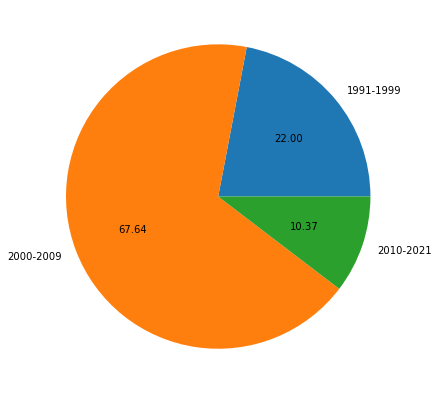

In [110]:
import matplotlib.pyplot as plt
import numpy as np

years = ["1991-1999", "2000-2009", "2010-2021"]
nums = [227,698,107]
y = np.array(nums)
mylabels = years
plt.figure(figsize=(10,7))
plt.pie(y, labels = mylabels, autopct='%1.2f')
plt.show() 

## years

## 5. Distribution over category

In [111]:
works = load_obj("germanistik")

In [112]:
cat={}

for work in works:
    if work.category != "none" and work.references != "none":
        category = work.category.split(",")[0]
        
        if category in cat:
            cat[category] +=1
        else:
            cat[category] = 1

In [113]:
types = sorted(list(cat.items()),key= lambda x: x[1], reverse=True) 

In [114]:
types

[('Seminararbeit', 231),
 ('Hausarbeit', 155),
 ('Hausarbeit (Hauptseminar)', 114),
 ('Ausarbeitung', 20),
 ('Referat (Ausarbeitung)', 12),
 ('Magisterarbeit', 10),
 ('Essay', 7),
 ('Facharbeit (Schule)', 6),
 ('Referat (Handout)', 6),
 ('Examensarbeit', 6),
 ('Referat / Aufsatz (Schule)', 6),
 ('Bachelor Thesis', 5),
 ('Bachelorarbeit', 4),
 ('Diplomarbeit', 3),
 ('Skript', 3),
 ('Akademische Arbeit', 2),
 ('Forschungsarbeit', 2),
 ("Master's Thesis", 2),
 ('Projektarbeit', 1),
 ('Masterarbeit', 1),
 ('Doktorarbeit / Dissertation', 1),
 ('Zwischenprüfungsarbeit', 1),
 ('Lizentiatsarbeit', 1),
 ('Rezension / Literaturbericht', 1),
 ('Presentation slides', 1),
 ('Textbook', 1),
 ('Term Paper', 1)]

## 6. Language Distribution

In [115]:
works = load_obj("germanistik")

In [124]:
languages = {}
for work in tqdm(works):
    if work.references != "none":
        refs = work.references.split("\n")
        for ref in refs:
            if len(ref) > 60:
                try:
                    lang = detect(ref)
                    if lang not in languages:
                        languages[lang] = 1
                    else:
                        languages[lang] +=1
                except:
                    print(ref)
                
    
    

  0%|          | 0/1028 [00:00<?, ?it/s]

https://www.faz.net/aktuell/feuilleton/buecher/rezensionen/belletristik/rezension-belletristik-christian-kracht-faserland-152146.html
http://www.bstu.bund.de/DE/Wissen/Publikationen/Publikationen/handbuch_HA-XX_auerbach-braun-usw.html
http://www.boorberg.de/sixcms/media.php/358/pdfd_rrenmatt.pdf
http://boardsteinschwubbe.de/schwulenchronic/175.php (20.08.2014, 17:53)
http://www.kinofenster.de/filme/ausgaben/kf0410/geschichte_der_homosexualitaet/ (30.10.2014, 13:43)
http://www.leuphana.de/medienkulturwiki/medienkulturwiki2/index.php?oldid=424> (11.09.2011)
http://www.perlentaucher.de/autoren/16167.html (07.03.2006) http://www.uni-heidelberg.de/uni/presse/RuCa2_98/kiesel.htm (15.01.2006).
http://www.uni-essen.de/linguistik.buenting/varietaetenscript1.pdf
http://www.seume.de/Sites/Spazier/Spazier.htm (10.10.2005) http://de.wikipedia.org (18.10.2005)
http://www.djfl.de/entertainment/stars/c/christoph_schlingensief_united.html (09.07.05).
http://www.freitag.de/2000/42/0042/00421301.htm (12.

In [126]:
count = 0
for key, value in languages.items():
    count += value

In [128]:
for key, value in languages.items():
    languages[key] = round(value/count, 3)

In [129]:
languages

{'de': 0.92,
 'en': 0.065,
 'fr': 0.006,
 'ca': 0.001,
 'id': 0.001,
 'sw': 0.0,
 'pt': 0.001,
 'it': 0.001,
 'cs': 0.001,
 'et': 0.001,
 'hu': 0.0,
 'sv': 0.002,
 'nl': 0.001,
 'cy': 0.0,
 'af': 0.0,
 'es': 0.0,
 'hr': 0.0,
 'pl': 0.001,
 'no': 0.0,
 'lt': 0.0,
 'ru': 0.001,
 'sk': 0.0,
 'da': 0.0,
 'sl': 0.0,
 'ro': 0.0,
 'sq': 0.0,
 'bg': 0.0}

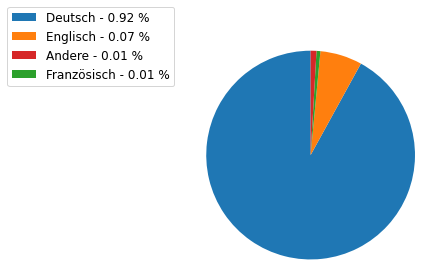

In [144]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([0.92,0.065, 0.006, 0.009])
mylabels = ["Deutsch", "Englisch", "Französisch","Andere"]

patches, texts = plt.pie(y, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(mylabels, list(y))]
sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=12)

plt.show() 
